# Optimización de Parámetros - ARIMA

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import os
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'gruas')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/gruas


In [3]:
import pandas as pd


In [4]:
import optuna
import datetime

In [5]:
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results
from modulos.arima.gruas.optimizer import ARIMAOptimizer

In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,idArticulo,ventas,DescProducto,Periodo
0,tuerc,7,TUERCA,2021-05-01
1,tuerc,5,TUERCA,2020-12-01
2,tuerc,1,TUERCA,2020-11-01
3,tuerc,11,TUERCA,2020-09-01
4,tuerc,4,TUERCA,2020-06-01


In [7]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,arandel,bateriascanrec,filtrodeair,filtrodepresio,filtroderetorn,pern,soport,tuerc
Periodo,,,,,,,,
2021-06-01,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0
2021-07-01,0.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0
2021-08-01,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-09-01,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2021-10-01,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0


## Optimizando un solo Producto

## Baseline ARIMA

In [8]:
   
idArticulo = 'filtrodeair'
result = total_forecasting(df_time[[idArticulo]])
    

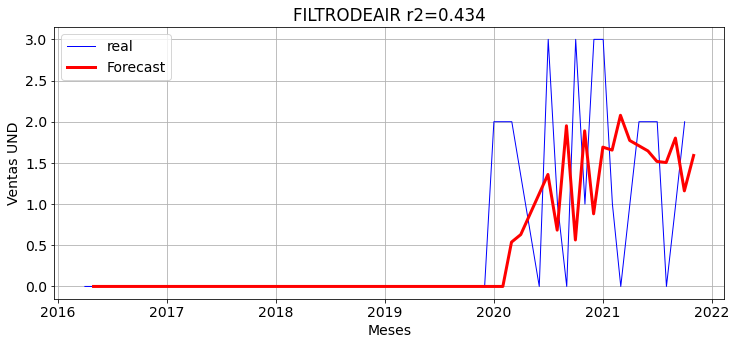

In [9]:
    
r2_baseline = show_results_r2(df_time, result, idArticulo)

# Optimizar todos los Productos        
        

In [10]:
optimizer = ARIMAOptimizer(df_time, iterations=100, data_path= DATA_PATH , model='ARIMA')
optimizer.run( chunk_size=4)

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


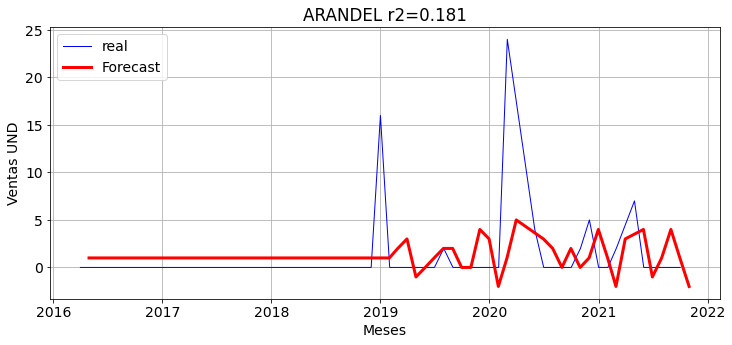

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


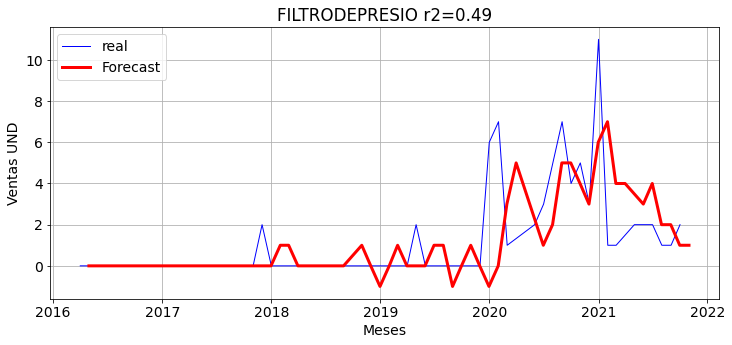

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


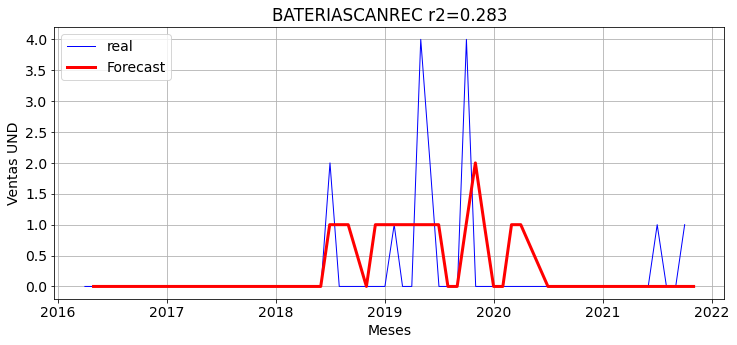

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


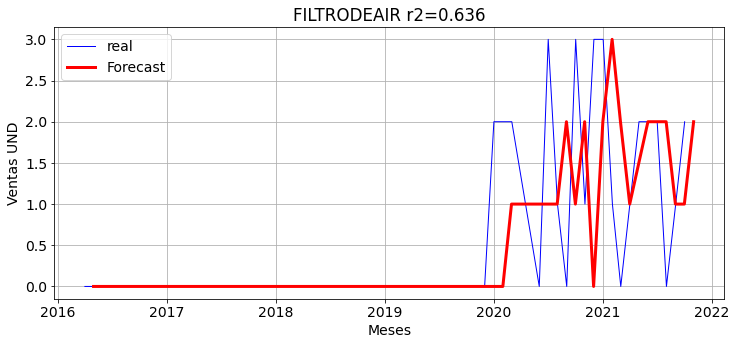

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


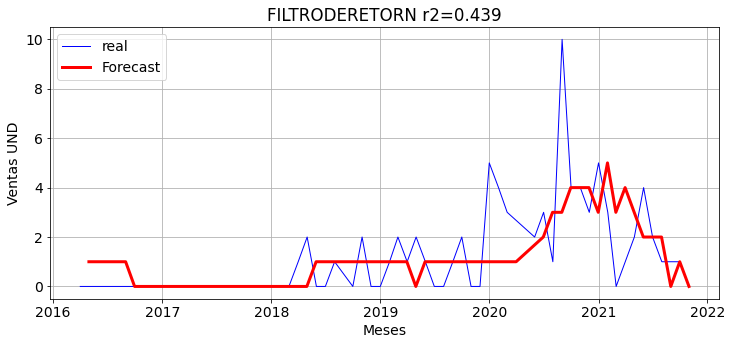

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


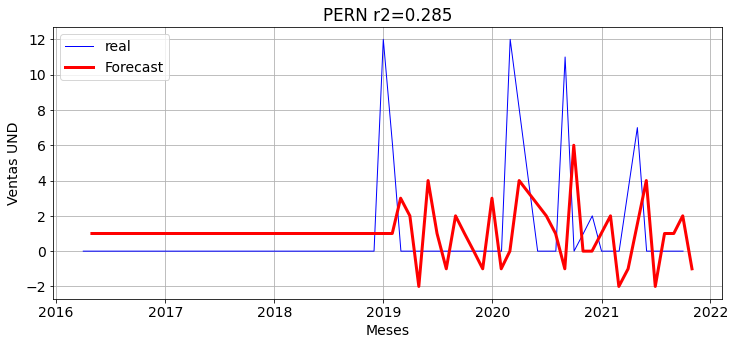

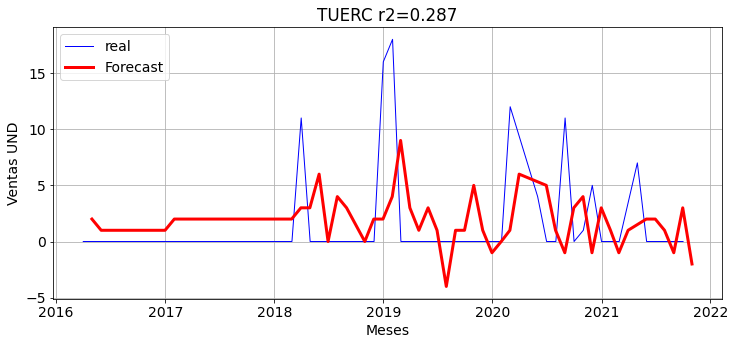

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


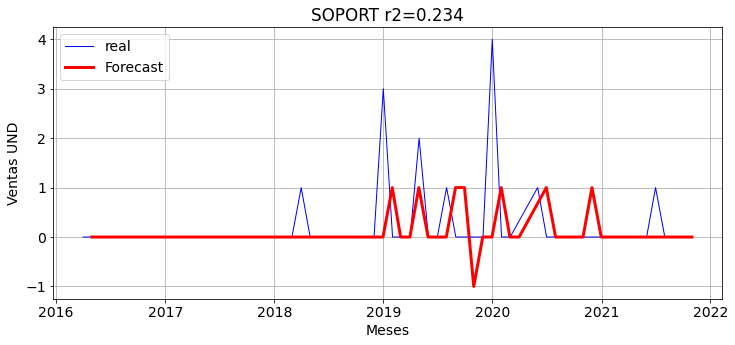

In [11]:
optimizer.print_results()

# Optimizer -  Evolution on time

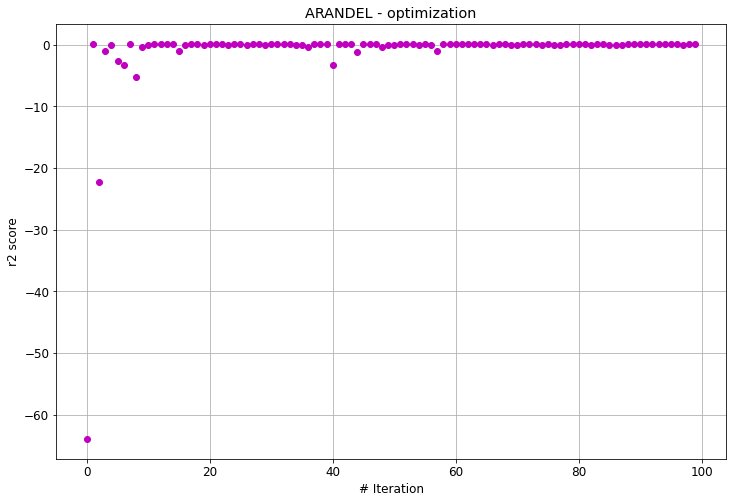

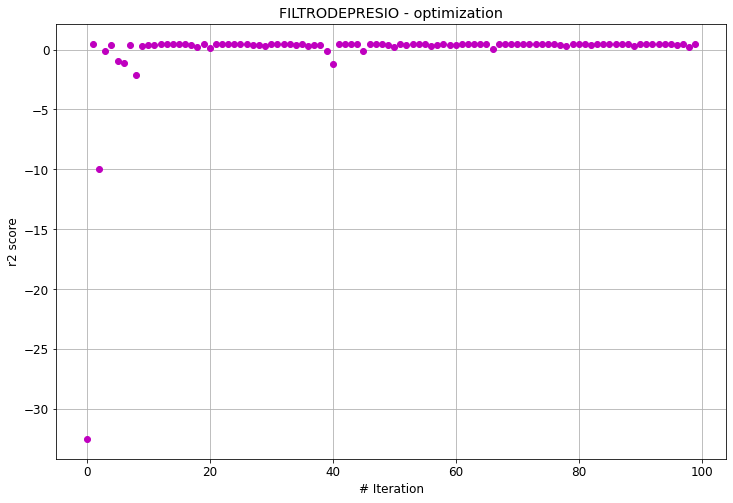

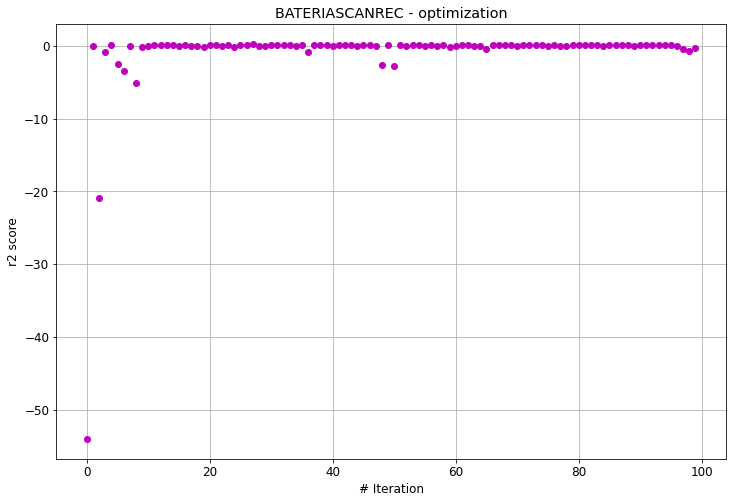

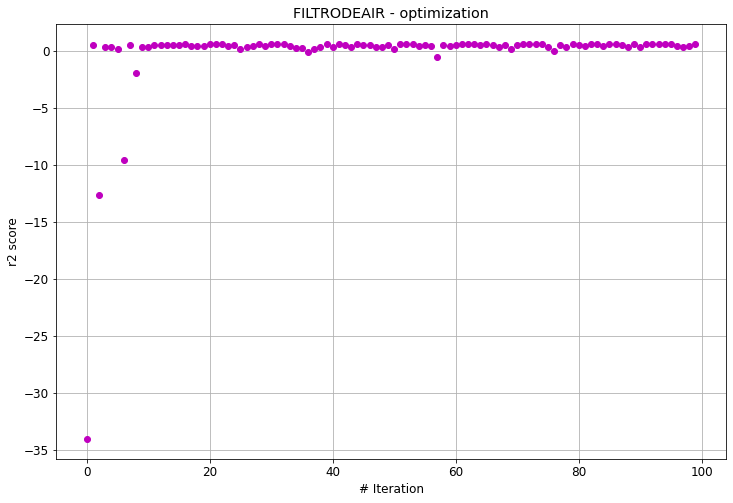

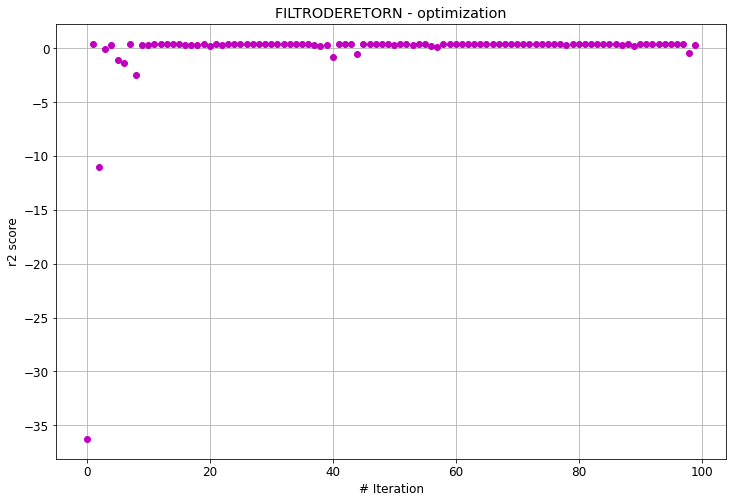

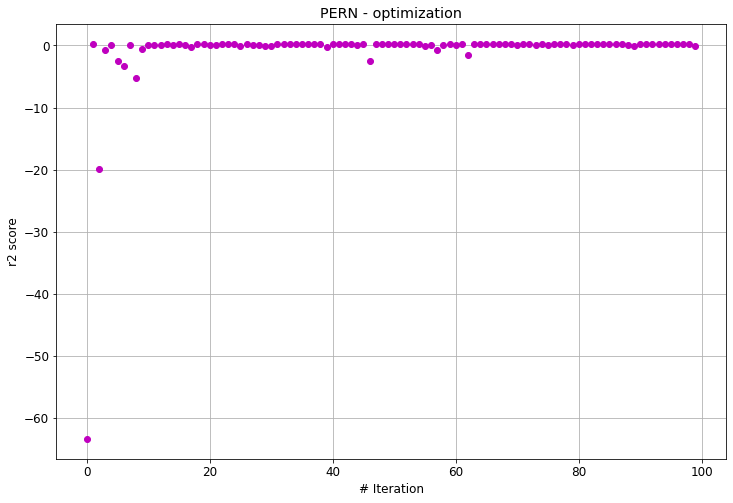

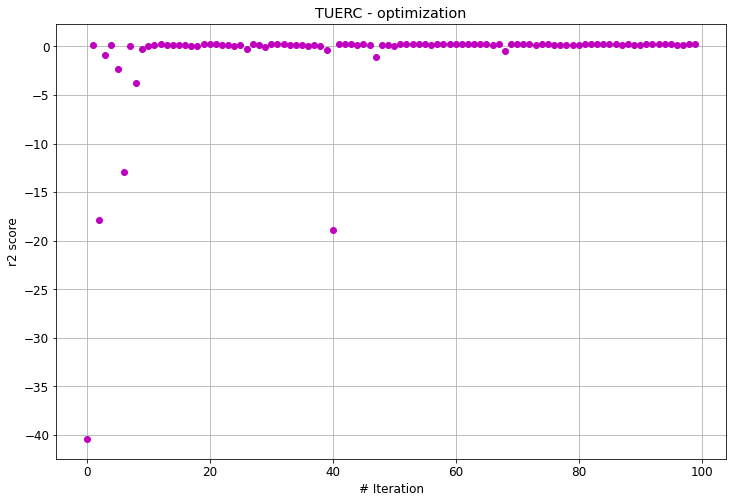

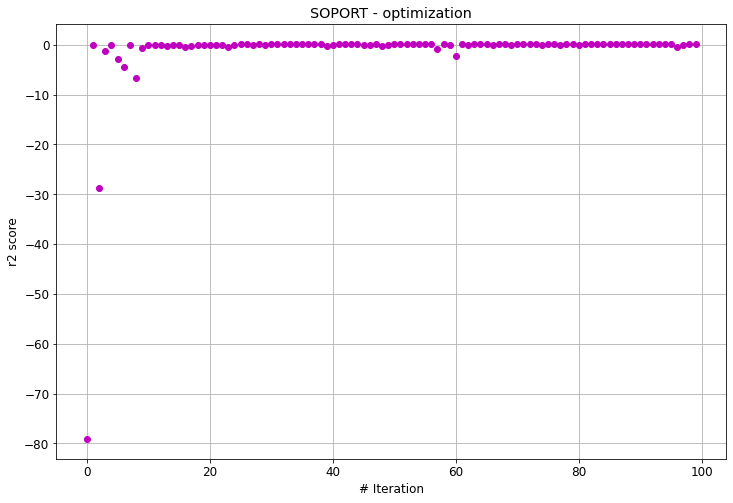

In [12]:
optimizer.print_optimizer_results()

In [13]:
optimizer.results

,idArticulo,hyper,r2,model
0,arandel,"{'ar': 5, 'ii': 0, 'ma': 4}",0.180670,ARIMA
1,filtrodepresio,"{'ar': 5, 'ii': 1, 'ma': 5}",0.489573,ARIMA
2,bateriascanrec,"{'ar': 6, 'ii': 0, 'ma': 5}",0.283019,ARIMA
3,filtrodeair,"{'ar': 5, 'ii': 2, 'ma': 5}",0.636089,ARIMA
4,filtroderetorn,"{'ar': 4, 'ii': 0, 'ma': 5}",0.438574,ARIMA
5,pern,"{'ar': 6, 'ii': 0, 'ma': 6}",0.285349,ARIMA
6,tuerc,"{'ar': 5, 'ii': 0, 'ma': 6}",0.287285,ARIMA
7,soport,"{'ar': 4, 'ii': 0, 'ma': 6}",0.234229,ARIMA
